In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import sympy as sym

from sklearn.metrics import accuracy_score

# REGRESSION
Since I don't have the price for all the parts I need for my analysis I am going to estimate the price for those I don't using a Regression.

## EDA

In [2]:
df_parts = pd.read_csv('./data/REBRICKABLE/parts.csv')
df_price = pd.read_csv('./data/pickabric_price_new.csv',sep=";")
df_volume = pd.read_csv('./data/BRICKLINK/parts_volume.csv', sep=';')

In [3]:
df = pd.merge(df_price, df_parts, on="part_num", how="inner")

In [4]:
df.drop(columns=['Name','design_id','name'], inplace=True)

In [5]:
df['Price']=df['Price'].str.replace("$","")
df['Price']=df['Price'].apply(lambda x: eval(x))

In [6]:
df_volume.drop(columns=['Alternate Item Number','Category ID','Category Name', 'Name'], inplace=True)

In [7]:
df_volume.rename(columns={'Number':'part_num'}, inplace=True)

In [8]:
df_volume.dropna(subset=['Weight (in Grams)'],inplace=True)

In [9]:
Vdf = pd.merge(df, df_volume, on="part_num", how="inner")

Part material has no relevance, so no dummies conversion is needed. This is because +95% of the pieces are made in hard plastic (see pairplot below)

In [10]:
#dummies=pd.get_dummies(Vdf,columns=["part_material"], dtype=int)
#dummies=dummies[['part_material_Cloth', 'part_material_Flexible Plastic', 'part_material_Plastic','part_material_Rubber']]
#Vdf=pd.concat([Vdf,dummies], axis=1)
#Vdf.shape[0]-np.sum(Vdf['part_material_Plastic']) #Not enough to take conclusions

C:\Users\laiav\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1000x800 with 0 Axes>

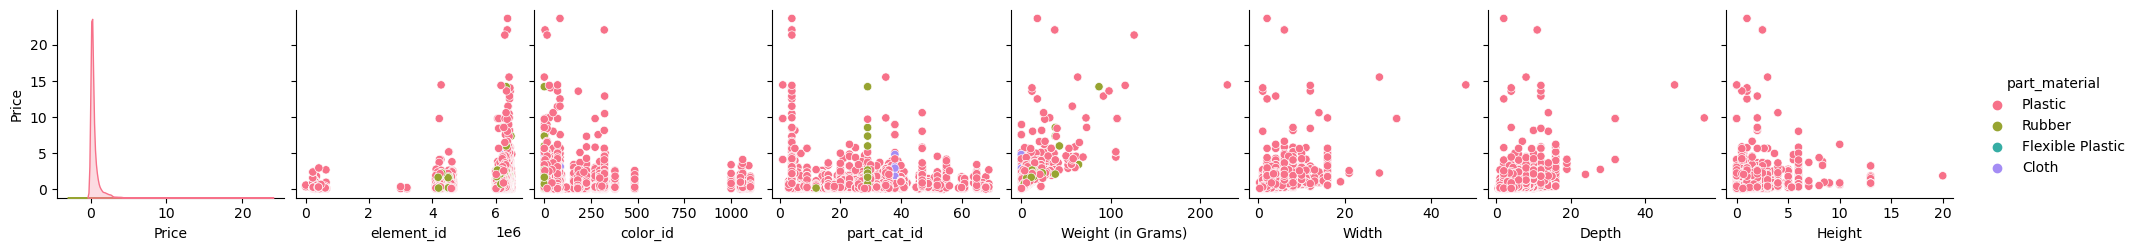

In [11]:
plt.figure(figsize=(10, 8))
sns.pairplot(data = Vdf, y_vars = 'Price',hue='part_material', palette='husl') 

plt.show();

C:\Users\laiav\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1000x800 with 0 Axes>

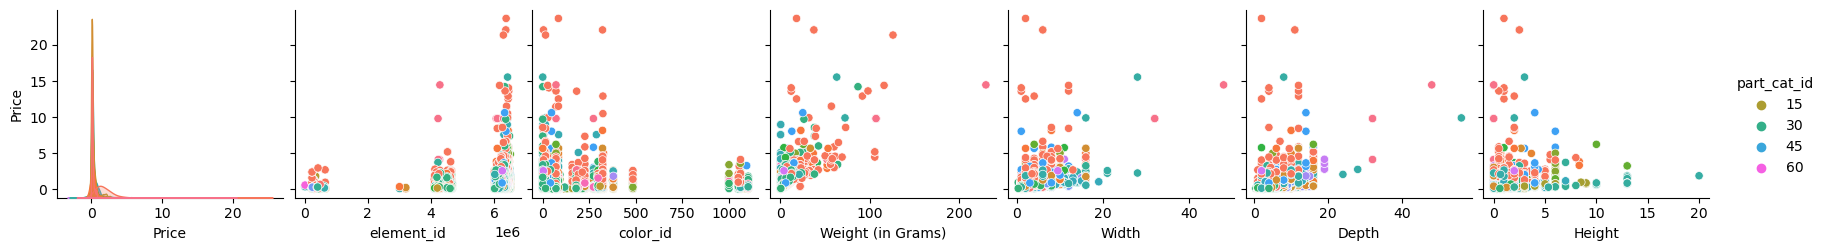

In [12]:
plt.figure(figsize=(10, 8))
sns.pairplot(data = Vdf, y_vars ='Price',hue='part_cat_id', palette='husl') 

plt.show();

we can see that the weight is related to the price in a "linear" way, but since there are too many outliers first I am going to clean the data

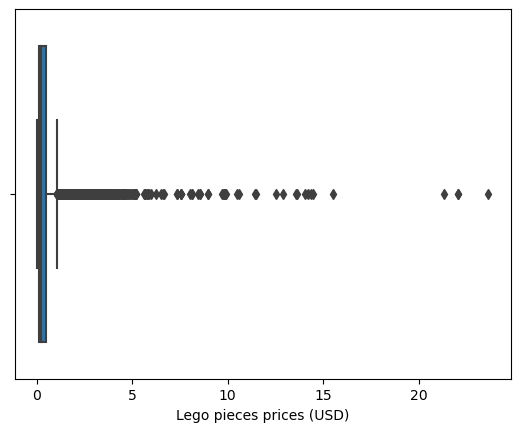

In [13]:
sns.boxplot(data=Vdf, x="Price")
plt.xlabel("Lego pieces prices (USD)")  
plt.show()

In [14]:
Q75 = np.percentile(Vdf["Price"], 75)
Q25 = np.percentile(Vdf["Price"], 25)
IQR = Q75 - Q25

In [15]:
lower_limit = Q25 - 1.5*IQR
upper_limit = Q75 + 1.5*IQR

In [16]:
Vdf_filtered = Vdf[(Vdf['Price']>lower_limit) & (Vdf['Price']<upper_limit)]
Vdf_outliers = Vdf[(Vdf['Price']<lower_limit) & (Vdf['Price']>upper_limit)]

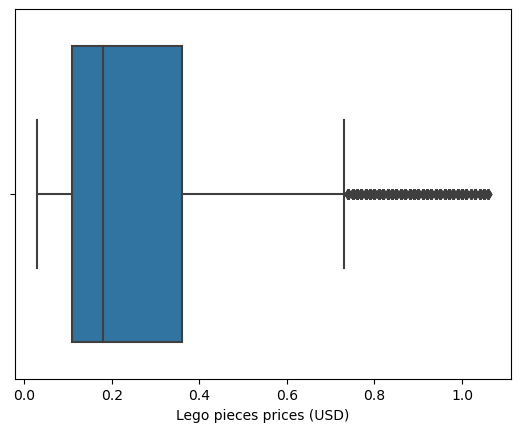

In [17]:
sns.boxplot(data=Vdf_filtered, x="Price")
plt.xlabel("Lego pieces prices (USD)")  # Label for the x-axis
plt.show()

C:\Users\laiav\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1000x800 with 0 Axes>

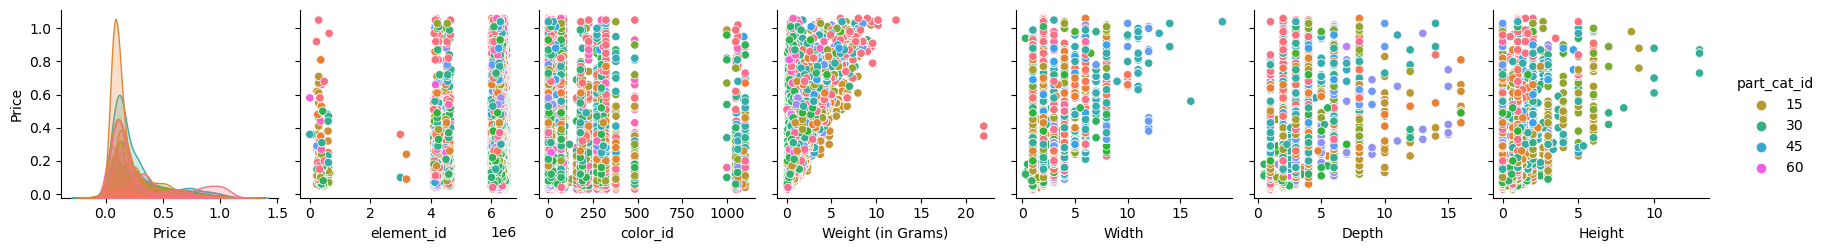

In [18]:
plt.figure(figsize=(10, 8))
sns.pairplot(data = Vdf_filtered, y_vars = 'Price',hue='part_cat_id', palette='husl') 

plt.show();

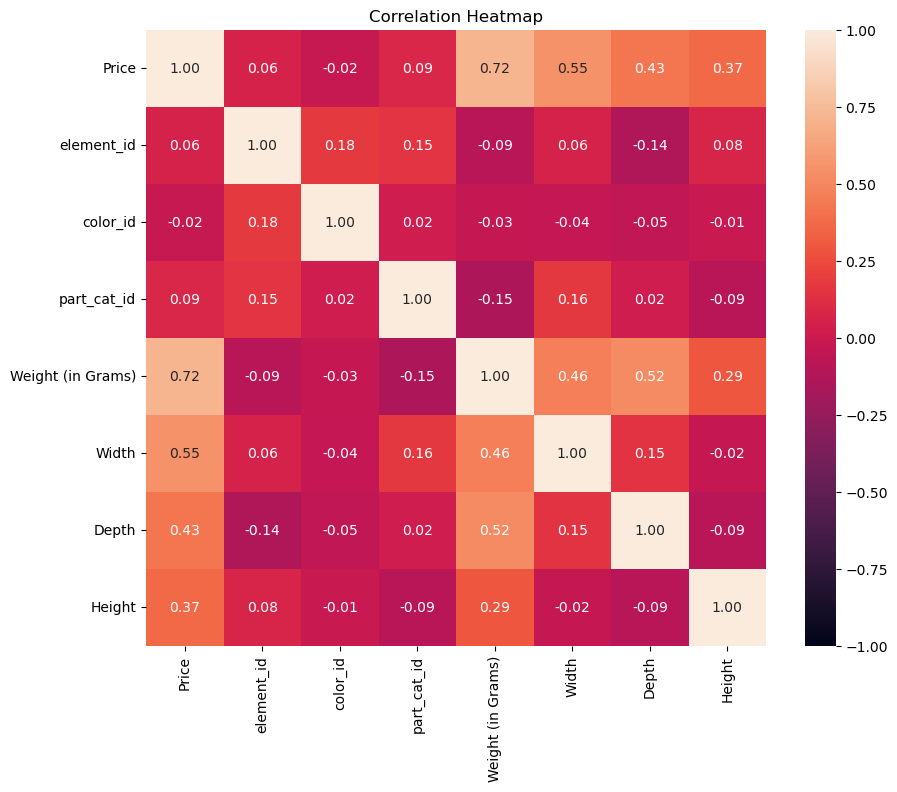

In [19]:
plt.figure(figsize=(10, 8))
plt.title('Correlation Heatmap')
sns.heatmap(Vdf_filtered.corr(numeric_only = True), annot = True, vmin = -1, vmax = 1, fmt=".2f") 
plt.show()

I'll divide my data in 3 clusters, one in which I have info about weight and size, other for those I only have weight and a last one for those I only have the base data

## Cluster1 WEIGHT + DIMENSIONS
Here we will train a regression model with the weight and dimensions. This is the ideal case

In [20]:
#R2 0.6573842177422131 Using Weight + Dimensions not filtered
#Vdf_nona=Vdf.dropna()

#X = Vdf_nona[list(Vdf_nona.drop(columns=['part_num', 'Serial','Price','element_id', 'part_material']))] 
#Y = Vdf_nona['Price']

In [21]:
#R2 0.7824580172505344 We choose this one Using Weight + Dimensions and filtered
Vdf_filtered_nona=Vdf_filtered.dropna()

X1 = Vdf_filtered_nona[list(Vdf_filtered_nona.drop(columns=['part_num', 'Serial','Price','element_id', 'part_material']))] 
Y1 = Vdf_filtered_nona['Price']

In [22]:
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1, Y1, test_size=0.2) 

In [23]:
lm1 = LinearRegression() 
lm1.fit(X1_train, Y1_train)

LinearRegression()

In [24]:
lm1.score(X1, Y1)

0.7809328559325407

In [25]:
# R^2 is given by using the .score() function
print(f'Training score: {lm1.score(X1_train, Y1_train):.2f}')
print(f'Testing score: {lm1.score(X1_test, Y1_test):.2f}')

Training score: 0.78
Testing score: 0.77


In [26]:
Y1_pred_lm= lm1.predict(X1_test)

In [27]:
rmse1 = np.sqrt(mean_squared_error(Y1_test, Y1_pred_lm))
print(f'RMSE: {rmse1:.2f}')
mae1 = mean_absolute_error(Y1_test,  Y1_pred_lm)
print(f'MAE: {mae1:.2f}')

RMSE: 0.10
MAE: 0.06


In [28]:
import statsmodels.api as sm

SX = sm.add_constant(X1)

# OLS stands for ordinary least squares (aka line of best fit) - the type of regression model we are using
model1= sm.OLS(Y1,X1, hasconst=True) 

res1=model1.fit()
res1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     5502.
Date:                Fri, 22 Mar 2024   Prob (F-statistic):               0.00
Time:                        16:40:05   Log-Likelihood:                 6486.2
No. Observations:                7752   AIC:                        -1.296e+04
Df Residuals:                    7746   BIC:                        -1.292e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
color_id          -1.477e-05   6.24e-06     -2.369      0.018    -2.7e-05   -2.55e-06
part_cat_id           0.0006   6.71e-05      8.240      0.000       0.000       0.001
Weight (in Grams)     0.0809      0.001     81.533      0.000       0.079       0.083
Width                 0.0262      0.001     37.861      0.000       0.025       0.028
Depth                 0.0056      0.001     10.573      0.000       0.005       0.007
Height                0.0341      0.001     34.071      0.000       0.032       0.036
==============================================================================
Omnibus:                     3452.497   Durbin-Watson:                   0.640
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           151133.648
Skew:                           1.415   Prob(JB):                         0.00
Kurtosis:                      24.445   Cond. No.                         229.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [29]:
from sklearn.model_selection import cross_val_score

cross_val1=cross_val_score(lm1,X1,Y1,cv=10)
print(cross_val1)
print(f'cross validation R2 mean: {cross_val1.mean()}')

[0.56447002 0.84290472 0.65458064 0.79762778 0.75606948 0.64944412
 0.74899236 0.7174336  0.5122904  0.53320837]
cross validation R2 mean: 0.677702149276349


## Cluster 2 WEIGHT
Here we will train a regression model without the dimensions

In [30]:
#R2 0.5735357865787722 Using Using Weight not filtered
#X = Vdf[list(Vdf.drop(columns=['part_num', 'Serial','Price','element_id', 'part_material','Width','Depth','Height']))] 
#Y = Vdf['Price']

In [31]:
#R2 0.5737723718516288 Using Using Weight and filtered
X2 = Vdf_filtered[list(Vdf_filtered.drop(columns=['part_num', 'Serial','Price','element_id', 'part_material','Width','Depth','Height']))] 
Y2 = Vdf_filtered['Price']

In [32]:
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2, Y2, test_size=0.2) 

In [33]:
lm2 = LinearRegression() 
lm2.fit(X2_train, Y2_train)

LinearRegression()

In [34]:
lm2.score(X2, Y2)

0.548208016443126

In [35]:
# R^2 is given by using the .score() function
print(f'Training score: {lm2.score(X2_train, Y2_train):.2f}')
print(f'Testing score: {lm2.score(X2_test, Y2_test):.2f}')

Training score: 0.56
Testing score: 0.51


In [36]:
Y2_pred_lm= lm2.predict(X2_test)

rmse1 = np.sqrt(mean_squared_error(Y1_test, Y1_pred_lm))
print(f'RMSE: {rmse1:.2f}')
mae1 = mean_absolute_error(Y1_test,  Y1_pred_lm)
print(f'MAE: {mae1:.2f}')

RMSE: 0.10
MAE: 0.06


In [37]:
cross_val2=cross_val_score(lm2,X2,Y2,cv=10)
print(cross_val2)
print(f'cross validation R2 mean: {cross_val2.mean()}')

[0.36256576 0.35176509 0.58807197 0.42204797 0.43175555 0.45352838
 0.65698813 0.49855946 0.00205293 0.24322772]
cross validation R2 mean: 0.40105629446488217


## Cluster 3 BASE DATA
Here we will train a regression model without the weight and dimensions. We can see the results are really bad. So for these cases, we will do an average of the weight per part category and feed it to the second algorithm

In [38]:
#R2 0.5737723718516288 Using Using Weight and filtered
X3 = Vdf_filtered[list(Vdf_filtered.drop(columns=['part_num', 'Serial','Price','element_id', 'part_material','Width','Depth','Height','Weight (in Grams)']))] 
Y3 = Vdf_filtered['Price']

In [39]:
X3_train, X3_test, Y3_train, Y3_test = train_test_split(X3, Y3, test_size=0.2) 

In [40]:
lm3 = LinearRegression() 
lm3.fit(X3_train, Y3_train)

LinearRegression()

In [41]:
lm3.score(X3, Y3)

0.007404840166618909

# PREDICTIONS
Now we want to generate predictions of the prices we are missing. But first we need to prepare the data

## EDA

In [42]:
df_inventory = pd.read_csv('./data/inventories_price.csv',sep=';', encoding = 'latin-1')
df_inventory_parts = pd.read_csv('./data/REBRICKABLE/inventory_parts.csv')
df_colors = pd.read_csv('./data/REBRICKABLE/colors.csv')

In [43]:
df_partsneeded =  pd.merge(df_inventory, df_inventory_parts, on="inventory_id", how="left")

In [44]:
df_partsneeded.rename(columns={'img_url_x': "img_url_set",'img_url_y': "img_url_piece",'price':'set_price'}, inplace=True)

In [45]:
df_colors.rename(columns={'id':'color_id','name':'color_name'},inplace=True)

In [46]:
df_partsneeded =  pd.merge(df_partsneeded, df_parts, on="part_num", how="left")

In [47]:
df_partsneeded.rename(columns={'name_x': "set_name",'name_y': "piece_name"}, inplace=True)

In [48]:
df_partsneeded =  pd.merge(df_partsneeded, df_colors, on="color_id", how="left")

In [49]:
df_partsneeded =  pd.merge(df_partsneeded, df_volume, on="part_num", how="left")

In [50]:
df_partsneeded['artificialkey'] = df_partsneeded['part_num'].astype(str)+'-'+df_partsneeded['color_id'].astype(str)

In [51]:
df_price['artificialkey'] = df_price['part_num'].astype(str)+'-'+df_price['color_id'].astype(str)

In [52]:
df_price=df_price.sort_values(by='Price')

In [53]:
df_price['isduplicated']=df_price['artificialkey'].duplicated()

In [54]:
df_partsneeded=  pd.merge(df_partsneeded, df_price[df_price['isduplicated']==False].drop(columns=['Name','Serial','part_num','element_id','design_id','color_id','isduplicated']), on="artificialkey", how="left")

In [55]:
df_price['artificialkey'].nunique()

14501

In [56]:
df_partsneeded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171527 entries, 0 to 171526
Data columns (total 27 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   inventory_id       171527 non-null  int64  
 1   version            171527 non-null  int64  
 2   set_num            171527 non-null  object 
 3   set_name           171527 non-null  object 
 4   year               171527 non-null  int64  
 5   theme_id           171527 non-null  int64  
 6   theme_name         171527 non-null  object 
 7   num_parts          171527 non-null  int64  
 8   img_url_set        171527 non-null  object 
 9   set_price          171527 non-null  float64
 10  part_num           171527 non-null  object 
 11  color_id           171527 non-null  int64  
 12  quantity           171527 non-null  int64  
 13  is_spare           171527 non-null  object 
 14  img_url_piece      171295 non-null  object 
 15  piece_name         171527 non-null  object 
 16  pa

In [57]:
#value_counts = df_price['artificialkey'].value_counts()
#df_price['count'] = df_price['artificialkey'].map(value_counts)

In [58]:
df_partsneeded.rename(columns={'Price':'piece_price'}, inplace=True)

## SEPARATION IN CASES
Now we can see we have a dataset with 168761 entries. but not all of them have price, nor all the relevant information, so should be treated separately

In [59]:
df_no_price=df_partsneeded[df_partsneeded['piece_price'].isna()]

In [60]:
#delete the pieces without price
df_partsneeded.dropna(how='any', subset='piece_price',inplace=True)

In [61]:
df_partsneeded['piece_price']=df_partsneeded['piece_price'].str.replace("$","")
df_partsneeded['piece_price']=df_partsneeded['piece_price'].apply(lambda x: eval(x))

In [62]:
df_no_price_dimensions=df_no_price[df_no_price['Width'].isna()]
df_no_price.dropna(how='any', subset='Width',inplace=True)

C:\Users\laiav\AppData\Local\Temp\ipykernel_21768\4025670579.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_price.dropna(how='any', subset='Width',inplace=True)


In [63]:
df_no_price_weight=df_no_price_dimensions[df_no_price_dimensions['Weight (in Grams)'].isna()]
df_no_price_dimensions.dropna(how='any', subset='Weight (in Grams)',inplace=True)

C:\Users\laiav\AppData\Local\Temp\ipykernel_21768\4154280880.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_price_dimensions.dropna(how='any', subset='Weight (in Grams)',inplace=True)


Now all my data is stored in the following way:
- df_partsneeded : part info with actual price
- df_no_price : part info for those without price but all other data -> regression 1
- df_no_price_dimensions : part info for those without price nor dimensions -> regression 2
- df_no_price_weight : part info for those without price, dimensions or weight -> Estimate the average weight per category
    

In [64]:
total=df_partsneeded.shape[0]+ df_no_price.shape[0]+df_no_price_dimensions.shape[0]+df_no_price_weight.shape[0]
print('Data with price', df_partsneeded.shape[0], 'corresponds to', df_partsneeded.shape[0]/total*100,'%')
print('Data without price', df_no_price.shape[0], 'corresponds to', df_no_price.shape[0]/total*100,'%')
print('Data without price and dimensions', df_no_price_dimensions.shape[0], 'corresponds to', df_no_price_dimensions.shape[0]/total*100,'%')
print('Data without price , dimensions and weight', df_no_price_weight.shape[0], 'corresponds to', df_no_price_weight.shape[0]/total*100,'%')

Data with price 163465 corresponds to 95.29986532732457 %
Data without price 2460 corresponds to 1.4341765436345297 %
Data without price and dimensions 1832 corresponds to 1.0680534259912433 %
Data without price , dimensions and weight 3770 corresponds to 2.1979047030496655 %


### Data without price , dimensions and weight
We will estimate the weight assuming it won't variate much in between parts of the same category in most of the cases

In [65]:
weight_dict=pd.concat([df_partsneeded,df_no_price,df_no_price_dimensions]).groupby(by='part_cat_id')['Weight (in Grams)'].mean().dropna().to_dict()

median_weight = pd.concat([df_partsneeded,df_no_price,df_no_price_dimensions]).groupby(by='part_cat_id')['Weight (in Grams)'].mean().dropna().median()

for i in df_no_price_weight['part_cat_id']:
    if i not in list(weight_dict.keys()):
        weight_dict[i] = median_weight

In [66]:
df_no_price_weight['Weight (in Grams)'] = df_no_price_weight['Weight (in Grams)'].fillna(df_no_price_weight['part_cat_id'].map(weight_dict))

C:\Users\laiav\AppData\Local\Temp\ipykernel_21768\862281622.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_price_weight['Weight (in Grams)'] = df_no_price_weight['Weight (in Grams)'].fillna(df_no_price_weight['part_cat_id'].map(weight_dict))


In [67]:
df_no_price_dimensions = pd.concat([df_no_price_dimensions,df_no_price_weight],ignore_index=True)

In [68]:
df_no_price_dimensions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5602 entries, 0 to 5601
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   inventory_id       5602 non-null   int64  
 1   version            5602 non-null   int64  
 2   set_num            5602 non-null   object 
 3   set_name           5602 non-null   object 
 4   year               5602 non-null   int64  
 5   theme_id           5602 non-null   int64  
 6   theme_name         5602 non-null   object 
 7   num_parts          5602 non-null   int64  
 8   img_url_set        5602 non-null   object 
 9   set_price          5602 non-null   float64
 10  part_num           5602 non-null   object 
 11  color_id           5602 non-null   int64  
 12  quantity           5602 non-null   int64  
 13  is_spare           5602 non-null   object 
 14  img_url_piece      5381 non-null   object 
 15  piece_name         5602 non-null   object 
 16  part_cat_id        5602 

With this we can proceed to predict the price with the case2 regression

## Data without price and dimensions
we will predict the price using the Case 2 regression

In [69]:
df_no_price_dimensions['piece_price'] = lm2.predict(df_no_price_dimensions[['color_id','part_cat_id','Weight (in Grams)']])

In [70]:
df_no_price_dimensions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5602 entries, 0 to 5601
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   inventory_id       5602 non-null   int64  
 1   version            5602 non-null   int64  
 2   set_num            5602 non-null   object 
 3   set_name           5602 non-null   object 
 4   year               5602 non-null   int64  
 5   theme_id           5602 non-null   int64  
 6   theme_name         5602 non-null   object 
 7   num_parts          5602 non-null   int64  
 8   img_url_set        5602 non-null   object 
 9   set_price          5602 non-null   float64
 10  part_num           5602 non-null   object 
 11  color_id           5602 non-null   int64  
 12  quantity           5602 non-null   int64  
 13  is_spare           5602 non-null   object 
 14  img_url_piece      5381 non-null   object 
 15  piece_name         5602 non-null   object 
 16  part_cat_id        5602 

## Data without price
we will predict the price using the Case 1 regression

In [71]:
df_no_price['piece_price'] = lm1.predict(df_no_price[['color_id','part_cat_id','Weight (in Grams)','Width','Depth','Height']])

C:\Users\laiav\AppData\Local\Temp\ipykernel_21768\2574012318.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_price['piece_price'] = lm1.predict(df_no_price[['color_id','part_cat_id','Weight (in Grams)','Width','Depth','Height']])


In [72]:
df_no_price.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2460 entries, 77 to 171516
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   inventory_id       2460 non-null   int64  
 1   version            2460 non-null   int64  
 2   set_num            2460 non-null   object 
 3   set_name           2460 non-null   object 
 4   year               2460 non-null   int64  
 5   theme_id           2460 non-null   int64  
 6   theme_name         2460 non-null   object 
 7   num_parts          2460 non-null   int64  
 8   img_url_set        2460 non-null   object 
 9   set_price          2460 non-null   float64
 10  part_num           2460 non-null   object 
 11  color_id           2460 non-null   int64  
 12  quantity           2460 non-null   int64  
 13  is_spare           2460 non-null   object 
 14  img_url_piece      2452 non-null   object 
 15  piece_name         2460 non-null   object 
 16  part_cat_id        2460 no

## Final Join and data export:


In [73]:
mydata = pd.concat([df_partsneeded, df_no_price, df_no_price_dimensions],ignore_index=True)

In [74]:
mydata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171527 entries, 0 to 171526
Data columns (total 27 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   inventory_id       171527 non-null  int64  
 1   version            171527 non-null  int64  
 2   set_num            171527 non-null  object 
 3   set_name           171527 non-null  object 
 4   year               171527 non-null  int64  
 5   theme_id           171527 non-null  int64  
 6   theme_name         171527 non-null  object 
 7   num_parts          171527 non-null  int64  
 8   img_url_set        171527 non-null  object 
 9   set_price          171527 non-null  float64
 10  part_num           171527 non-null  object 
 11  color_id           171527 non-null  int64  
 12  quantity           171527 non-null  int64  
 13  is_spare           171527 non-null  object 
 14  img_url_piece      171295 non-null  object 
 15  piece_name         171527 non-null  object 
 16  pa

In [75]:
mydata.drop(columns='artificialkey', inplace=True)

In [76]:
for i in mydata['part_cat_id']:
    if i not in list(weight_dict.keys()):
        weight_dict[i] = median_weight
        print(i, weight_dict[i])

In [77]:
mydata['Weight (in Grams)'] = mydata['Weight (in Grams)'].fillna(mydata['part_cat_id'].map(weight_dict))

In [78]:
mydata['Weight (in Grams)'] = mydata['Weight (in Grams)'].round(3)
mydata['Width'] = mydata['Width'].round(3)
mydata['Depth'] = mydata['Depth'].round(3)
mydata['Height'] = mydata['Height'].round(3)
mydata['piece_price'] = mydata['piece_price'].round(2)

In [79]:
mydata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171527 entries, 0 to 171526
Data columns (total 26 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   inventory_id       171527 non-null  int64  
 1   version            171527 non-null  int64  
 2   set_num            171527 non-null  object 
 3   set_name           171527 non-null  object 
 4   year               171527 non-null  int64  
 5   theme_id           171527 non-null  int64  
 6   theme_name         171527 non-null  object 
 7   num_parts          171527 non-null  int64  
 8   img_url_set        171527 non-null  object 
 9   set_price          171527 non-null  float64
 10  part_num           171527 non-null  object 
 11  color_id           171527 non-null  int64  
 12  quantity           171527 non-null  int64  
 13  is_spare           171527 non-null  object 
 14  img_url_piece      171295 non-null  object 
 15  piece_name         171527 non-null  object 
 16  pa

In [80]:
pd.DataFrame(mydata).to_csv('whole_price_dataset.csv',index=False,encoding='utf-8-sig')